This notebook contains code to train a linear classifier on MNIST. The principal changes from the previous notebook are:

* We have switched from regression to classification.

* We are using a different loss function. Instead of using squared error, we will now use cross-entropy.

* We are using a new dataset. MNIST contains 28x28 pixel handwritten digits.

An important takeaway: notice that despite these changes, the line that creates the gradient descent optimizer is identical to the previous notebook. This is the magic of automatic differentiation. Once we've specified our graph and the loss function, TensorFlow is able to analyze it for us, and determine how to adjust our variables to decrease the loss.

The model we train here is unimpressive in terms of accuracy. The goal is to introduce you to the dataset. At the end is a short exercise.

Experiment with this notebook by running the cells and uncommenting code when asked. 

When you've finished with this notebook, move on to the next one which will modify our linear classifier into a deep neural network, and adds code to visualize the graph in TensorBoard.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

import numpy as np

import pylab
%matplotlib inline

In [2]:
tf.reset_default_graph()
sess = tf.Session()

In [3]:
# Import the MNIST dataset. 
# It will be downloaded to '/tmp/data' if you don't already have a local copy.
mnist = input_data.read_data_sets('/tmp/data', one_hot=True)
export_dir = "/tmp/logisticregression/1"

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Train, validation, test: 55000, 5000, 10000
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
8
784


Text(0.5,1,u'Label: 8')

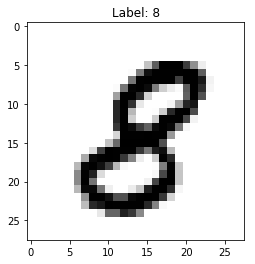

In [4]:
# Uncomment these lines to understand the format of the dataset.

# 1. There are 55k, 5k, and 10k examples in train, validation, and test.
print ('Train, validation, test: %d, %d, %d' % 
       (len(mnist.train.images), len(mnist.validation.images), len(mnist.test.images)))

# 2. The format of the labels is 'one-hot'.
# The fifth image happens to be a '6'.
# This is represented as '[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]'
print (mnist.train.labels[5])

# You can find the index of the label, like this:
print (np.argmax(mnist.train.labels[5]))

# 3. An image is a 'flattened' array of 28*28 = 784 pixels.
print (len(mnist.train.images[5]))

# 4. To display an image, first reshape it to 28x28.
pylab.imshow(mnist.train.images[5].reshape((28,28)), cmap=pylab.cm.gray_r)   
pylab.title('Label: %d' % np.argmax(mnist.train.labels[5])) 

In [5]:
NUM_CLASSES = 10
NUM_PIXELS = 28 * 28
TRAIN_STEPS = 2000
BATCH_SIZE = 100
LEARNING_RATE = 0.5

In [6]:
# Define inputs
images = tf.placeholder(dtype=tf.float32, shape=[None, NUM_PIXELS])
labels = tf.placeholder(dtype=tf.float32, shape=[None, NUM_CLASSES])

In [20]:
serialized_tf_example = tf.placeholder(tf.string, name='tf_example')
feature_configs = {'x': tf.FixedLenFeature(shape=[784], dtype=tf.float32),}
tf_example = tf.parse_example(serialized_tf_example, feature_configs)

# Define model
x = tf.identity(tf_example['x'], name='x')
W = tf.Variable(tf.truncated_normal([NUM_PIXELS, NUM_CLASSES]))
b = tf.Variable(tf.zeros([NUM_CLASSES]))
y = tf.matmul(images, W) + b

In [21]:
# Define loss and optimizer
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y, labels=labels))
train_step = tf.train.GradientDescentOptimizer(LEARNING_RATE).minimize(loss) 

In [22]:
# Initialize variables after the model is defined
sess.run(tf.global_variables_initializer())

In [23]:
# Train the model
for i in range(TRAIN_STEPS):
    batch_images, batch_labels = mnist.train.next_batch(BATCH_SIZE)
    sess.run(train_step, feed_dict={images: batch_images, labels: batch_labels})

In [24]:
values, indices = tf.nn.top_k(y, 10)
table = tf.contrib.lookup.index_to_string_table_from_tensor(tf.constant([str(i) for i in xrange(10)]))
prediction_classes = table.lookup(tf.to_int64(indices))

In [25]:
# Evaluate the trained model
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(labels, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
                                  
print("Accuracy %f" % sess.run(accuracy, feed_dict={images: mnist.test.images, 
                                                    labels: mnist.test.labels}))

Accuracy 0.892000


As written, this code evaluates the accuracy of the trained model on the entire testing set. Below is a function to predict the label for a single image.

Predicted: 7, actual: 7


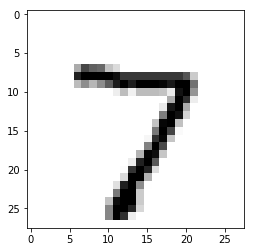

In [26]:
prediction = tf.argmax(y,1)

def predict(i):
    image = mnist.test.images[i]
    actual_label = np.argmax(mnist.test.labels[i])
    predicted_label = sess.run(prediction, feed_dict={images: [image]})
    return predicted_label, actual_label

i = 0
predicted, actual = predict(i)
print ("Predicted: %d, actual: %d" % (predicted, actual))
pylab.imshow(mnist.test.images[i].reshape((28,28)), cmap=pylab.cm.gray_r) 

In [28]:
# save model
builder = tf.saved_model.builder.SavedModelBuilder(export_dir)

classification_inputs = tf.saved_model.utils.build_tensor_info(serialized_tf_example)
classification_outputs_classes = tf.saved_model.utils.build_tensor_info(prediction_classes)
classification_outputs_scores = tf.saved_model.utils.build_tensor_info(values)

classification_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={ tf.saved_model.signature_constants.CLASSIFY_INPUTS:classification_inputs },
          outputs={ tf.saved_model.signature_constants.CLASSIFY_OUTPUT_CLASSES: classification_outputs_classes,
              tf.saved_model.signature_constants.CLASSIFY_OUTPUT_SCORES: classification_outputs_scores
          },
          method_name=tf.saved_model.signature_constants.CLASSIFY_METHOD_NAME))

tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
tensor_info_y = tf.saved_model.utils.build_tensor_info(y)

prediction_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={'images': tensor_info_x},
          outputs={'scores': tensor_info_y},
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

legacy_init_op = tf.group(tf.tables_initializer(), name='legacy_init_op')
builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={ 'predict_images': prediction_signature,
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY: classification_signature,
      },
      legacy_init_op=legacy_init_op)

builder.save()

INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: /tmp/logisticregression/1/saved_model.pb


'/tmp/logisticregression/1/saved_model.pb'